# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [19]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset import

In [6]:
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "rap")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

(964605, 8)


,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Killa Cam,rap,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",en,en
1,Can I Live,rap,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...,en,en
3,Down and Out,rap,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...,en,en
4,Fly In,rap,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",en,en


In [7]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [8]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/rap_lyrics.parquet",
    index=False
)

In [9]:
# Chargement du df filtré
df = pd.read_parquet("data/rap_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Descriptive statistics

In [ ]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
RangeIndex: 964605 entries, 0 to 964604
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   title   964538 non-null  str  
 1   artist  964605 non-null  str  
 2   year    964605 non-null  int64
 3   views   964605 non-null  int64
 4   lyrics  964605 non-null  str  
dtypes: int64(2), str(3)
memory usage: 2.1 GB


In [ ]:
df[["year", "views"]].describe()
# Incoherence in values for year and views (min)

,year,views
count,964605.000000,9.646050e+05
mean,2014.790266,5.882038e+03
std,57.264063,8.041827e+04
min,1.000000,0.000000e+00
25%,2015.000000,2.000000e+01
50%,2018.000000,6.900000e+01
75%,2020.000000,5.280000e+02
max,2027.000000,1.757563e+07


In [12]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1    649
2      6
3      3
5      1
6      6
Name: count, dtype: int64

In [ ]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(963628, 5)

In [ ]:
df["year"].describe()
# Now, the values make sense

count    963628.000000
mean       2016.463142
std           5.523159
min        1950.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

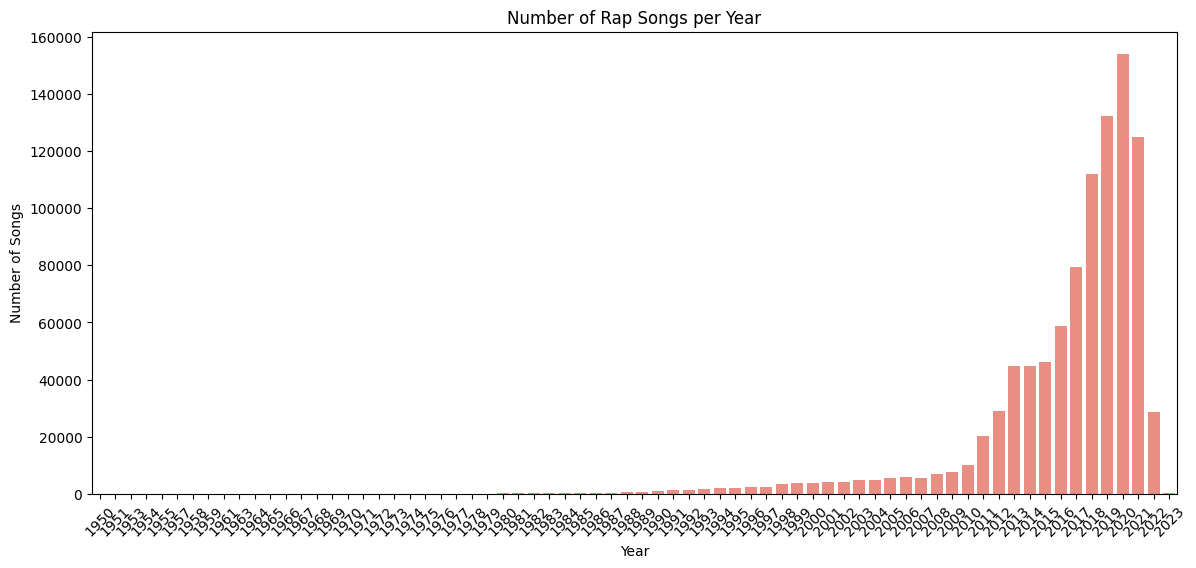

In [20]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Keeping only the years 2000s
df = df[(df["year"] >= 2000) & (df["year"] <= 2023)]
df.shape

(938866, 5)

In [22]:
df["artist"].value_counts().head(10)

artist
Genius English Translations    3707
Lil B                          1287
Gucci Mane                     1184
Juice WRLD                     1135
Lil Wayne                      1003
Chief Keef                      919
Muze Sikk                       917
OCTOBERSFULLMOON                886
BONES                           773
Kanye West                      768
Name: count, dtype: int64

## Pre processing

## NLP 

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(text)["compound"]

df["sentiment"] = df["clean_lyrics"].apply(vader_score)


In [ ]:
from collections import Counter

nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

nrc = nrc[nrc["association"] == 1]

emotion_map = (
    nrc.groupby("word")["emotion"]
    .apply(list)
    .to_dict()
)

def emotional_power(text):
    emotions = []
    for w in text.split():
        emotions.extend(emotion_map.get(w, []))
    return len(emotions)

df["emotional_power"] = df["clean_lyrics"].apply(emotional_power)


In [ ]:
yearly_stats = (
    df.groupby("year")
      .agg(
          mean_sentiment=("sentiment", "mean"),
          mean_emotion=("emotional_power", "mean"),
          song_count=("lyrics", "count")
      )
      .reset_index()
)

yearly_stats.head()


In [ ]:
df.to_parquet(
    "data/rap_lyrics_nlp_clean.parquet",
    index=False
)

## Visualisation of the results

In [ ]:
CRISIS_YEARS = {
    "dotcom": list(range(2000, 2003)),
    "financial_crisis": list(range(2008, 2010)),
    "covid": list(range(2020, 2022))
}

crisis_years = sum(CRISIS_YEARS.values(), [])

yearly["crisis"] = yearly["year"].isin(crisis_years)